In [29]:
import os
from pathlib import Path

In [30]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

In [31]:
data_dir = Path(os.getcwd()) / ".dataset"
train_directory = data_dir / "Training"
test_directory = data_dir / "Testing"

In [32]:
def plot_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    print(history.history.keys())
    epoch = range(len(loss))

    ax1.plot(epoch, loss, label="Training Loss")
    ax1.plot(epoch, val_loss, label="Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epoch, accuracy, label="Training Accuracy")
    ax2.plot(epoch, val_accuracy, label="Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

In [33]:
_seed = 9118487
validation_split = .2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
batch_size = 32
color_mode = "grayscale"


cnn_train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    validation_split=validation_split,
    subset='training',
    seed=_seed,
    image_size=image_size,
    color_mode=color_mode
)

cnn_validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    validation_split=validation_split,
    subset='validation',
    seed=_seed,
    image_size=image_size,
    color_mode=color_mode
)

cnn_test_dateset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    seed=_seed,
    image_size=image_size,
    color_mode=color_mode
)


cnn_train_dataset = cnn_train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

cnn_validation_dataset = cnn_validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

cnn_test_dateset = cnn_test_dateset.cache().prefetch(tf.data.AUTOTUNE)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [34]:
for batch in cnn_train_dataset.take(1):
  input_data_shape = batch[0].shape[1:]
  number_of_labels = len(batch[1][0, :])
  label = batch[1][0, :]

In [35]:
def create_cnn_model(input_shape=(224, 224, 1), num_classes=4):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=input_shape))

    # Block 1
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(.001),
    ))
    model.add(tf.keras.layers.BatchNormalization())

    # Block 2
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(.001)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.5))

    # Block 3
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(.001)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.6))

    # Fully connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=512,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(.001)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [40]:
# do not create and retrain the model if you don't have to :^)
create_model_flag = False
if create_model_flag:
    cnn_model = create_cnn_model(input_shape=input_data_shape, num_classes=number_of_labels)
else:
    path_to_final_cnn_model_dir = Path(os.getcwd()) / "final_cnn_model"
    cnn_model_json_path = path_to_final_cnn_model_dir / "config.json"
    with open(cnn_model_json_path, "r") as json_file:
        cnn_model_json = json_file.read()
    cnn_model = tf.keras.models.model_from_json(cnn_model_json)
    cnn_model_weights_path = path_to_final_cnn_model_dir / "model.weights.h5"
    cnn_model.load_weights(cnn_model_weights_path)

    # Load metadata if available
    cnn_metadata_path = path_to_final_cnn_model_dir / "metadata.json"
    if cnn_metadata_path.exists():
        import json
        with open(cnn_metadata_path, "r") as meta_file:
            cnn_metadata = json.load(meta_file)
        # Example: get class names or input shape
        class_names = cnn_metadata.get("class_names")
        input_shape = cnn_metadata.get("input_shape")
    

In [41]:
cnn_model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 224, 224, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,350,158 (73.81 MB)

 Trainable params: 6,449,636 (24.60 MB)

 Non-trainable params: 1,248 (4.88 KB)

 Optimizer params: 12,899,274 (49.21 MB)

In [9]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Evaluate model on the test set
test_loss, test_accuracy = cnn_model.evaluate(cnn_test_dateset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2025-06-26 23:16:20.503740: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 1/13 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6562 - loss: 3.1925

2025-06-26 23:16:20.896304: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 2/13 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.6797 - loss: 3.4440

2025-06-26 23:16:21.264085: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 3/13 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.6892 - loss: 3.5024

2025-06-26 23:16:21.608654: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 4/13 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.6947 - loss: 3.5266

2025-06-26 23:16:21.963071: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7209 - loss: 3.0835
Test Loss: 2.7376
Test Accuracy: 0.7259


In [10]:
class_labels = [path.stem for path in (Path(os.getcwd()) / ".dataset" / "Testing").iterdir()]
print(class_labels)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.90      0.19      0.31       100
meningioma_tumor       0.79      0.87      0.83       115
        no_tumor       0.66      0.93      0.77       105
 pituitary_tumor       0.70      0.93      0.80        74

        accuracy                           0.73       394
       macro avg       0.76      0.73      0.68       394
    weighted avg       0.77      0.73      0.68       394



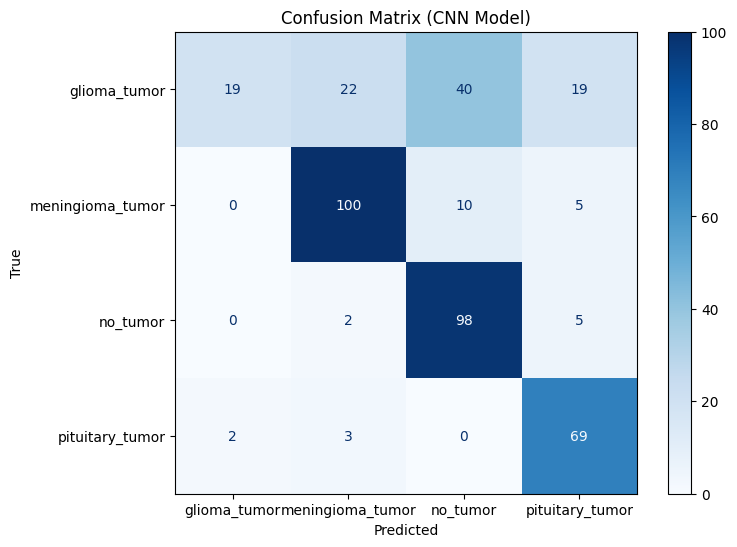

In [19]:
# Compute and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Get true labels and predictions
all_labels = []
all_preds = []
for images, labels in cnn_test_dateset:
    preds = cnn_model.predict(images)
    all_labels.extend(np.argmax(labels.numpy(), axis=1))
    all_preds.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_labels)

print("Classification Report:\n", report)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
# ax.invert_yaxis()
# plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.title("Confusion Matrix (CNN Model)")
plt.show()

In [42]:
class_names = class_labels

I0000 00:00:1751051594.354318   72790 service.cc:152] XLA service 0x7f9c0000add0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751051594.354366   72790 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-06-27 21:13:14.366556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751051594.652979   72790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


2025-06-27 21:13:26.383942: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


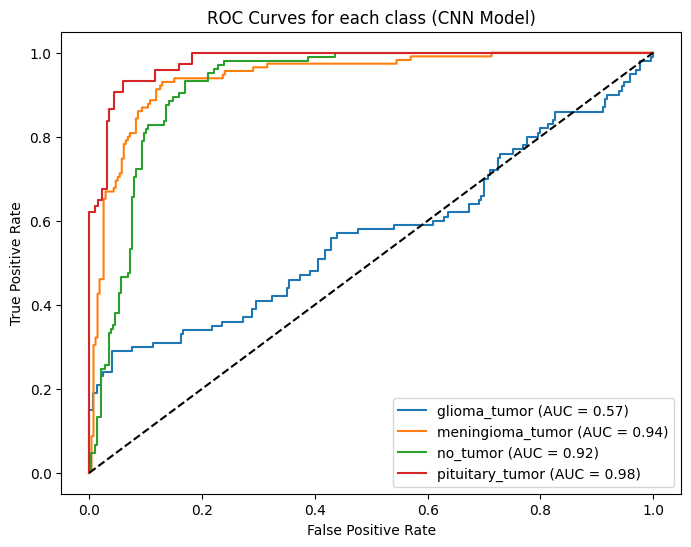

In [43]:
# Plot ROC curves for each class
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for each class and true labels
all_probs = []
all_true_labels = []
for images, labels in cnn_test_dateset:
    probs = cnn_model.predict(images)
    all_probs.append(probs)
    all_true_labels.extend(np.argmax(labels.numpy(), axis=1))
all_probs = np.concatenate(all_probs, axis=0)
all_true_labels = np.array(all_true_labels)

# One-hot encode the true labels
all_labels_onehot = tf.keras.utils.to_categorical(all_true_labels, num_classes=all_probs.shape[1])

plt.figure(figsize=(8, 6))
for i in range(all_probs.shape[1]):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each class (CNN Model)')
plt.legend()
plt.show()

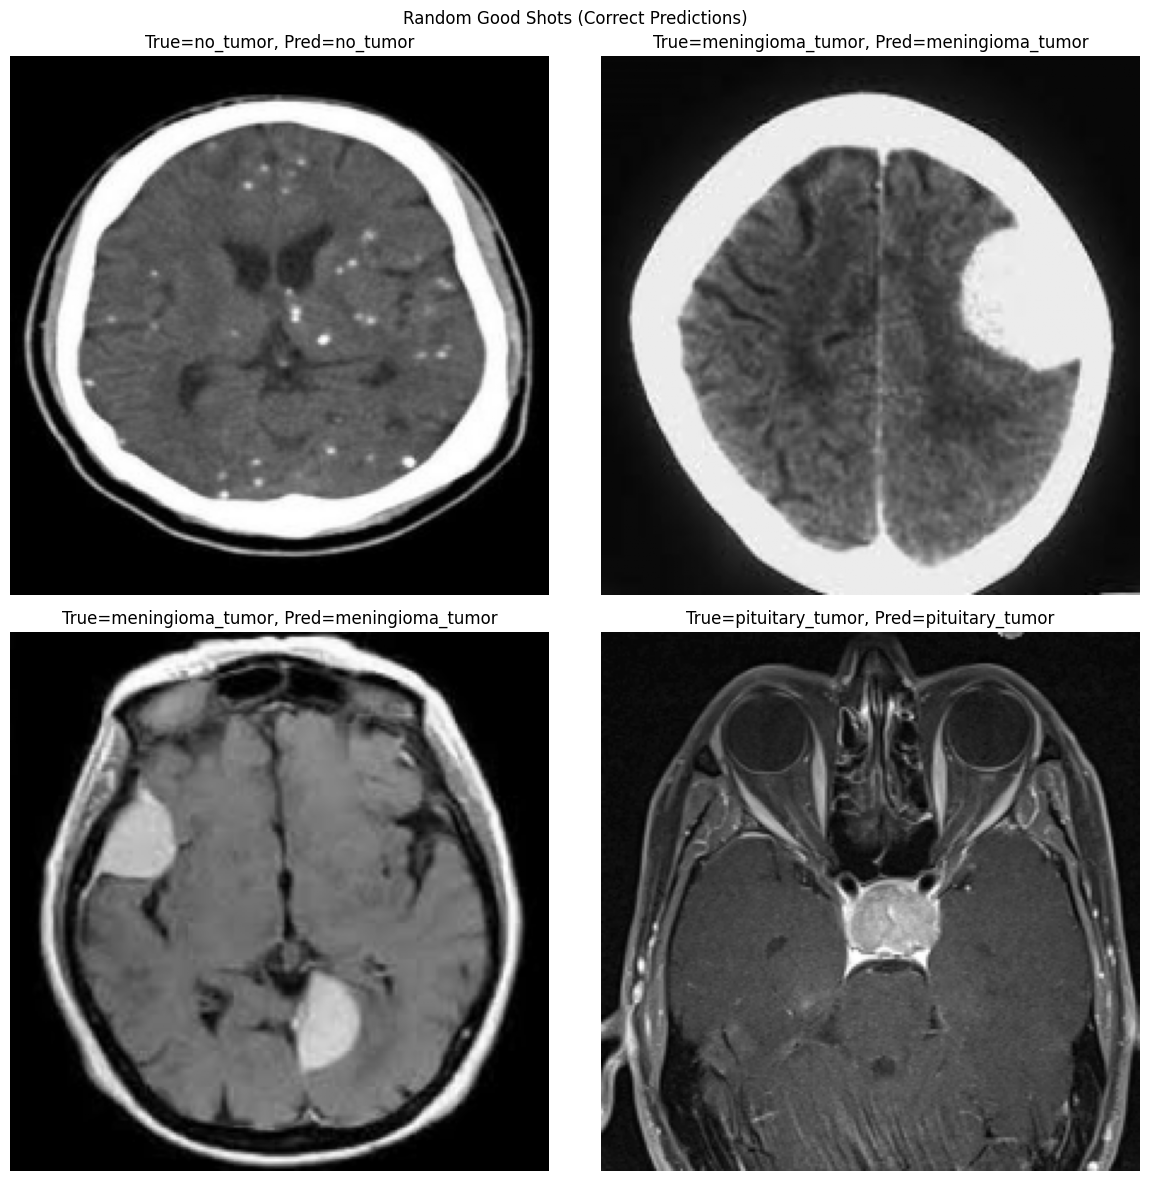

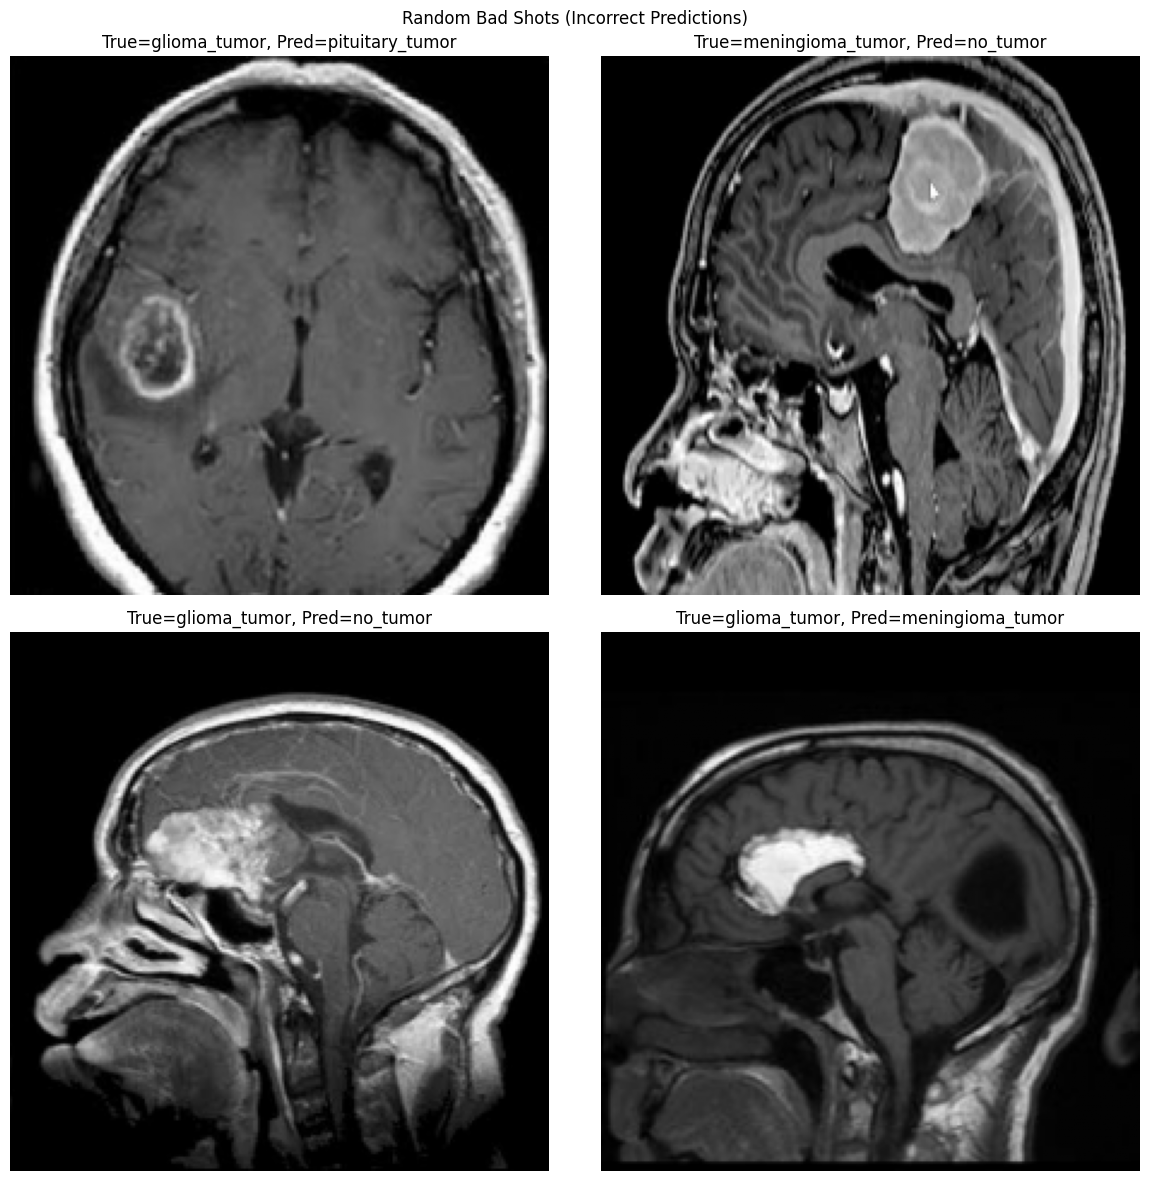

In [26]:
# Show random good and bad shots
import random

# Get all test images and their predictions
all_images = []
for images, labels in cnn_test_dateset:
    all_images.extend(images.numpy())
all_images = np.array(all_images)

# Use class_labels or class_names for mapping indices to names
try:
    label_names = class_labels
except NameError:
    label_names = class_names if 'class_names' in globals() else None
if label_names is None:
    raise ValueError("Class names not found. Please define class_labels or class_names.")

# Find indices of correct and incorrect predictions
correct_indices = [i for i, (y_true, y_pred) in enumerate(zip(all_labels, all_preds)) if y_true == y_pred]
incorrect_indices = [i for i, (y_true, y_pred) in enumerate(zip(all_labels, all_preds)) if y_true != y_pred]

# Select random good and bad shots (up to 4 for 2x2 grid)
n_samples = 4
random_good = random.sample(correct_indices, min(n_samples, len(correct_indices)))
random_bad = random.sample(incorrect_indices, min(n_samples, len(incorrect_indices)))

# Plot good shots (2x2 grid)
fig_good, axes_good = plt.subplots(2, 2, figsize=(12, 12))
axes_good = axes_good.flatten()
for i, idx in enumerate(random_good):
    axes_good[i].imshow(all_images[idx].squeeze(), cmap='gray')
    axes_good[i].set_title(f"True={label_names[all_labels[idx]]}, Pred={label_names[all_preds[idx]]}")
    axes_good[i].axis('off')
for i in range(len(random_good), 4):
    axes_good[i].axis('off')
fig_good.suptitle("Random Good Shots (Correct Predictions)")
plt.tight_layout()
plt.show()

# Plot bad shots (2x2 grid)
fig_bad, axes_bad = plt.subplots(2, 2, figsize=(12, 12))
axes_bad = axes_bad.flatten()
for i, idx in enumerate(random_bad):
    axes_bad[i].imshow(all_images[idx].squeeze(), cmap='gray')
    axes_bad[i].set_title(f"True={label_names[all_labels[idx]]}, Pred={label_names[all_preds[idx]]}")
    axes_bad[i].axis('off')
for i in range(len(random_bad), 4):
    axes_bad[i].axis('off')
fig_bad.suptitle("Random Bad Shots (Incorrect Predictions)")
plt.tight_layout()
plt.show()

In [68]:
class_labels

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

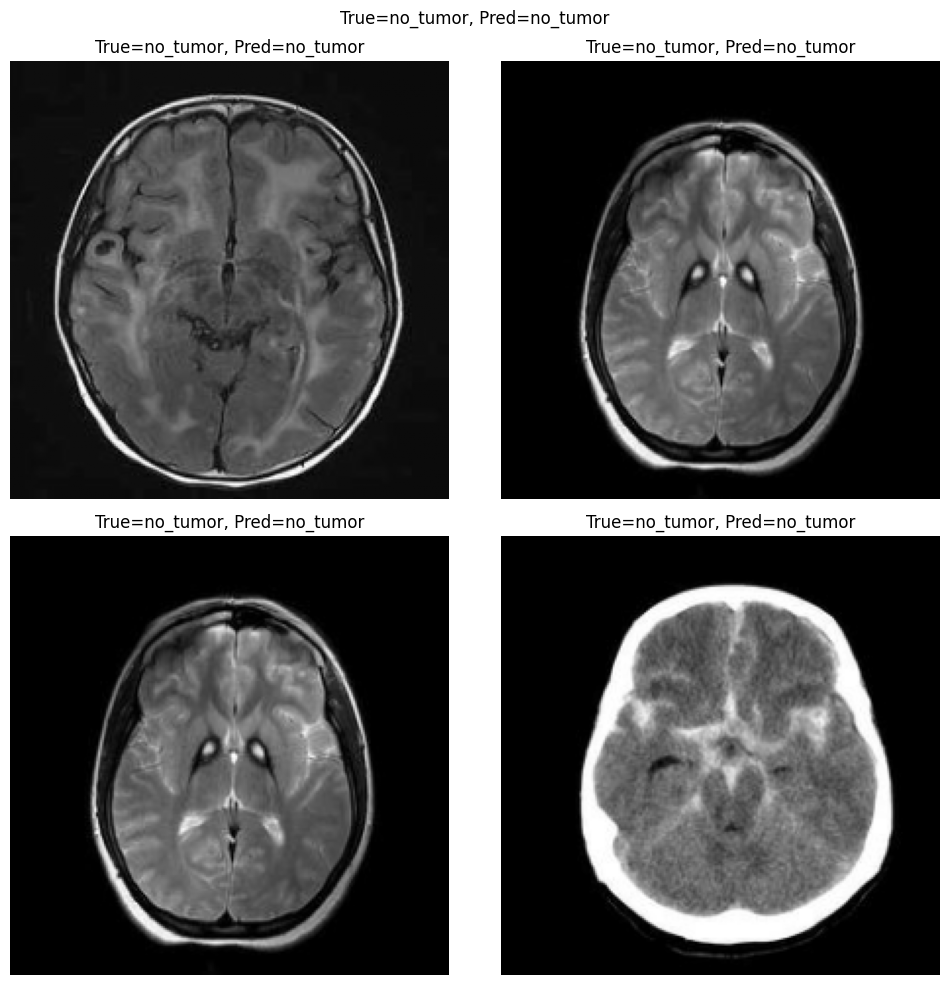

In [ ]:
def plot_misclassified_grid(true_label_name, pred_label_name, all_labels=all_labels, all_preds=all_preds, all_images=all_images, label_names=label_names, n_samples=4, swap=False):
    import random
    true_idx = None
    pred_idx = None
    for i, name in enumerate(label_names):
        if name == true_label_name:
            true_idx = i
        if name == pred_label_name:
            pred_idx = i
    if true_idx is None or pred_idx is None:
        raise ValueError(f"Could not find '{true_label_name}' or '{pred_label_name}' in label_names.")
    if not swap:
        indices = [i for i, (y_true, y_pred) in enumerate(zip(all_labels, all_preds)) if y_true == true_idx and y_pred == pred_idx]
        title = f"True={true_label_name}, Pred={pred_label_name}"
    else:
        indices = [i for i, (y_true, y_pred) in enumerate(zip(all_labels, all_preds)) if y_true == pred_idx and y_pred == true_idx]
        title = f"True={pred_label_name}, Pred={true_label_name}"
    selected = random.sample(indices, min(n_samples, len(indices)))
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, idx in enumerate(selected):
        axes[i].imshow(all_images[idx].squeeze(), cmap='gray')
        axes[i].set_title(title)
        axes[i].axis('off')
    for i in range(len(selected), 4):
        axes[i].axis('off')
    fig.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

# Example usage, you can swap true and predicted labels:
plot_misclassified_grid(true_label_name='no_tumor', pred_label_name='no_tumor')